# Introduction

This project analyzes customer revenue behavior using transactional sales data, with a focus on time-based revenue retention.
The dataset is provided by Kaggle (link). The analysis is exploratory and does not strictly follow the problem prompts provided on the Kaggle page. The analysis focuses on time-based revenue retention and customer revenue concentration, using pandas-based aggregation and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Data Overview
The dataset contains transactional sales records with one row per product line item.

In [3]:
sales = pd.read_csv('superstore_dataset.csv', encoding="latin1")

In [4]:
sales.shape

(9800, 18)

In [5]:
sales.describe()

,Row_ID,Postal_Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9800 non-null   int64  
 1   Order_ID       9800 non-null   object 
 2   Order_Date     9800 non-null   object 
 3   Ship_Date      9800 non-null   object 
 4   Ship_Mode      9800 non-null   object 
 5   Customer_ID    9800 non-null   object 
 6   Customer_Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal_Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product_ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub_Category   9800 non-null   object 
 16  Product_Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

# Data Cleaning and Preparation

In [7]:
# clean column
sales.columns = sales.columns.str.lower()

In [8]:
# change column type
sales[['order_date','ship_date']] = sales[['order_date','ship_date']].apply(pd.to_datetime, errors="coerce")

In [9]:
# check for nulls
sales.isna().sum()

row_id              0
order_id            0
order_date       5841
ship_date        5985
ship_mode           0
customer_id         0
customer_name       0
segment             0
country             0
city                0
state               0
postal_code        11
region              0
product_id          0
category            0
sub_category        0
product_name        0
sales               0
dtype: int64

Rows with missing order dates were excluded, as time-based analysis requires a valid transaction timestamp. This reduces the dataset but ensures consistency for cohort calculations.

In [10]:
sales[sales["order_date"].isna()]

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales
12,13,CA-2018-114412,NaT,NaT,Standard Class,AA-10480,Andrew Allen,Consumer,United States,Concord,North Carolina,28027.0,South,OFF-PA-10002365,Office Supplies,Paper,Xerox 1967,15.552
14,15,US-2016-118983,NaT,NaT,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,Texas,76106.0,Central,OFF-AP-10002311,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,68.810
15,16,US-2016-118983,NaT,NaT,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,Texas,76106.0,Central,OFF-BI-10000756,Office Supplies,Binders,Storex DuraTech Recycled Plastic Frosted Binders,2.544
17,18,CA-2015-167164,NaT,NaT,Second Class,AG-10270,Alejandro Grove,Consumer,United States,West Jordan,Utah,84084.0,West,OFF-ST-10000107,Office Supplies,Storage,Fellowes Super Stor/Drawer,55.500
18,19,CA-2015-143336,NaT,2015-01-09,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,California,94109.0,West,OFF-AR-10003056,Office Supplies,Art,Newell 341,8.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9791,9792,CA-2015-127166,NaT,NaT,Second Class,KH-16360,Katherine Hughes,Consumer,United States,Houston,Texas,77070.0,Central,OFF-EN-10003134,Office Supplies,Envelopes,Staple envelope,56.064
9792,9793,CA-2015-127166,NaT,NaT,Second Class,KH-16360,Katherine Hughes,Consumer,United States,Houston,Texas,77070.0,Central,FUR-CH-10003396,Furniture,Chairs,Global Deluxe Steno Chair,107.772
9793,9794,CA-2015-127166,NaT,NaT,Second Class,KH-16360,Katherine Hughes,Consumer,United States,Houston,Texas,77070.0,Central,OFF-PA-10001560,Office Supplies,Paper,"Adams Telephone Message Books, 5 1/4 x 11",4.832
9794,9795,CA-2015-127166,NaT,NaT,Second Class,KH-16360,Katherine Hughes,Consumer,United States,Houston,Texas,77070.0,Central,OFF-BI-10000977,Office Supplies,Binders,Ibico Plastic Spiral Binding Combs,18.240


In [11]:
sales_time = sales[sales["order_date"].notna()].copy()
sales_time

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales
0,1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-12-06,NaT,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-11-10,NaT,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-11-10,NaT,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,9787,US-2015-114377,2015-05-11,2015-05-11,Same Day,BG-11035,Barry Gonzalez,Consumer,United States,Hampton,Virginia,23666.0,South,FUR-CH-10004754,Furniture,Chairs,"Global Stack Chair with Arms, Black",149.9000
9796,9797,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


Each row represents a single product line item within an order. Multiple rows may share the same order_id, indicating multi-product purchases.

# Cohort Definition

Customers are assigned to cohorts based on their first purchase month. This allows tracking revenue behavior relative to their first purchase month (the customer’s acquisition period).

In [12]:
from datetime import datetime as dt

# Define Order Month for Each Line
sales_time['order_date'] = pd.to_datetime(sales_time['order_date'])
sales_time['month'] = sales_time['order_date'].dt.to_period('M')

# first order date
first_order = (
    sales_time
    .groupby('customer_id')['order_date']
    .min()
    .reset_index()
    .rename(columns={'order_date': 'first_order_date'})
)

# combine tables
sales_time = sales_time.merge(
    first_order,
    on='customer_id',
    how='left'
)

# define cohort month
sales_time['cohort_month'] = (
    sales_time['first_order_date']
    .dt.to_period('M')
    .dt.to_timestamp()
)

# cohort index
sales_time['cohort_index'] = (
    (sales_time['order_date'].dt.year - sales_time['first_order_date'].dt.year) * 12
    + (sales_time['order_date'].dt.month - sales_time['first_order_date'].dt.month)
    + 1
)

In [14]:
#final data table
sales_time

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,region,product_id,category,sub_category,product_name,sales,month,first_order_date,cohort_month,cohort_index
0,1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2017-08,2017-08-11,2017-08-01,1
1,2,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,2017-08,2017-08-11,2017-08-01,1
2,3,CA-2017-138688,2017-12-06,NaT,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2017-12,2017-12-06,2017-12-01,1
3,4,US-2016-108966,2016-11-10,NaT,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,2016-11,2016-04-12,2016-04-01,8
4,5,US-2016-108966,2016-11-10,NaT,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680,2016-11,2016-04-12,2016-04-01,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,9787,US-2015-114377,2015-05-11,2015-05-11,Same Day,BG-11035,Barry Gonzalez,Consumer,United States,Hampton,...,South,FUR-CH-10004754,Furniture,Chairs,"Global Stack Chair with Arms, Black",149.9000,2015-05,2015-05-11,2015-05-01,1
3955,9797,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,...,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680,2016-12,2016-12-01,2016-12-01,1
3956,9798,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,...,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880,2016-12,2016-12-01,2016-12-01,1
3957,9799,CA-2016-128608,2016-12-01,NaT,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,...,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760,2016-12,2016-12-01,2016-12-01,1


## Revenue Retention Analysis

Revenue retention measures how much revenue a customer cohort generates over time relative to their first purchase month. Cohort revenue is aggregated by cohort month and months since first purchase, then normalized against the first-month revenue.

In [24]:
# Calculate revenue for each month
cohort_revenue = sales_time.groupby(['cohort_index','cohort_month'])['sales'].sum().reset_index()
cohort_pivot = cohort_revenue.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='sales'
)

In [25]:
cohort_retention = cohort_pivot.divide(cohort_pivot[1], axis=0)

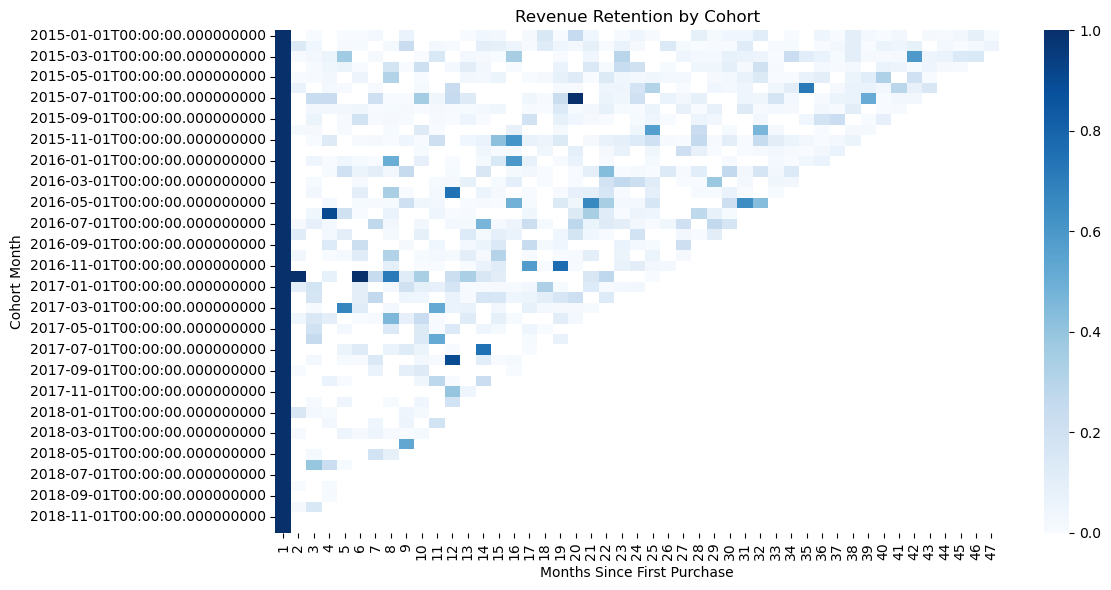

In [26]:
#visualise cohort
plt.figure(figsize=(12, 6))
sns.heatmap(
    cohort_retention,
    #annot=True,
    fmt='.0%',
    vmin=0,
    vmax=1,
    cmap='Blues'
)

plt.title('Revenue Retention by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

Revenue retention varies across cohorts with irregular patterns, reflecting the limitations of the dataset and the absence of recurring purchase structures.

## Revenue Concentration

This analysis examines how total revenue is distributed across customers to assess dependency on high-value customers.


In [27]:
# Calculate Revenue Generated by Customer
revenue = sales_time.groupby(['customer_id'])['sales'].sum().reset_index().sort_values(by='sales',ascending=False)

# Calculate Revenue Contribution from each customer
revenue['revenue_share'] = revenue['sales'] / revenue['sales'].sum()

In [28]:
# Find top revenue contributor
revenue = revenue.reset_index(drop=True)
revenue['customer_rank'] = revenue.index + 1

# Determine Cumulative Revenue Share Contribution
revenue['cumulative_revenue_share'] = revenue['revenue_share'].cumsum() * 100

Cumulative revenue share highlights how quickly total revenue accumulates as customers are ranked by contribution.

In [29]:
# Calculate Customer revenue Contribution Percentile
total_customer = len(revenue)
revenue['customer_percentile'] = revenue['customer_rank'] / total_customer * 100

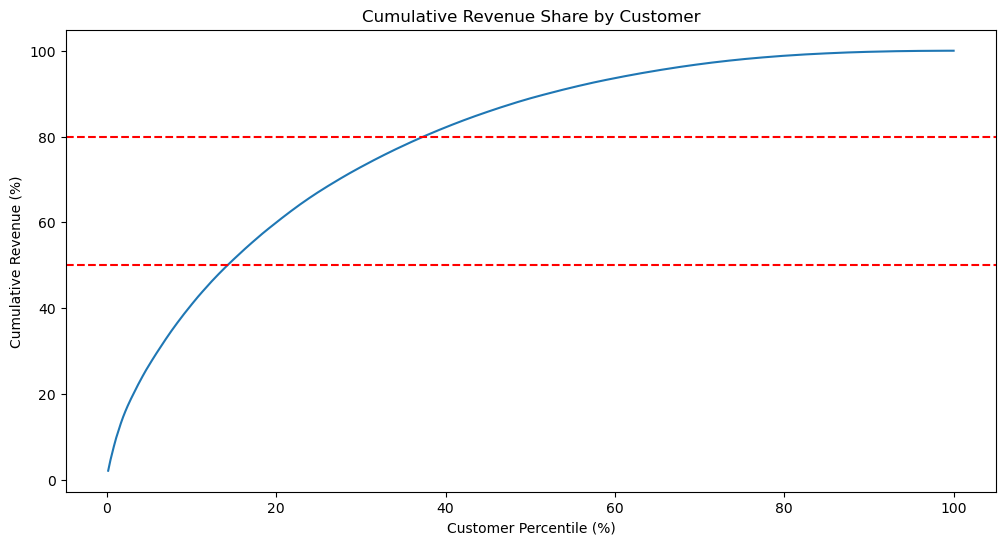

In [31]:
#Customer Revenue Share Curve
plt.figure(figsize=(12, 6))

plt.plot('customer_percentile','cumulative_revenue_share', data = revenue)

# reference line
plt.axhline(y=80, color='r', linestyle='--') 
plt.axhline(y=50, color='r', linestyle='--')

plt.xlabel('Customer Percentile (%)')
plt.ylabel('Cumulative Revenue (%)')
plt.title('Cumulative Revenue Share by Customer')
plt.show()

## Limitations

- Quantity data is unavailable, limiting unit-level analysis
- Missing order dates reduced the usable sample size
- Findings reflect historical transactional behavior only
